In [1]:
# Imports

import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from glob import glob
from random import shuffle
import numpy as np

In [31]:
DATADIR = "Dataset/"
NO_CLASS_LABEL='noclass'
IMG_SIZE = 150
IMG_CHANNELS=3
TRAIN_TEST_RATIO = 0.2

In [32]:
# List image addresses

labels = glob(DATADIR+'*/')
labels_str = [x.split('/')[-2] for x in labels]

# labels.insert(0, labels.pop(np.argmax([x.find(NO_CLASS_LABEL) for x in labels]))) # Push 'noclass' to the beginning

label_count = len(labels)
addrs = []

for (index, path) in enumerate(labels):
    img_addrs = glob(path+"*")
    for img_addr in img_addrs:
        addrs.append((img_addr, index))
        
shuffle(addrs)

division = int(len(addrs) * TRAIN_TEST_RATIO)
train_addrs = addrs[division:]
valid_addrs = addrs[0:division]

In [33]:
labels_str

['bird', 'noclass', 'bottle', 'lion']

In [34]:
# Read dataset into memory
x_train = np.zeros( (len(train_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int ) # Keras input: (img_height, img_width, img_depth)
y_train_list = np.zeros( len(train_addrs), dtype=np.int )

x_valid = np.zeros( (len(valid_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int )
y_valid_list = np.zeros( len(valid_addrs), dtype=np.int )

# Train data
for i in range(len(train_addrs)):
    addr = train_addrs[i][0]
    label = train_addrs[i][1]
    img = cv2.imread(addr)
    height, width, c = img.shape
    start_col = int(max(width/2-height/2, 0))
    end_col = int(min(start_col+height, width))
    img = img[:, start_col:end_col, ... ]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_train[i, ...] = img
    y_train_list[i] = label
    
# Validation data
for i in range(len(valid_addrs)):    
    addr = valid_addrs[i][0]
    label = valid_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_valid[i, ...] = img
    y_valid_list[i] = label

In [35]:
# One hot encode labels
y_train = np.zeros((y_train_list.shape[0],label_count),dtype=np.float)
y_valid = np.zeros((y_valid_list.shape[0],label_count),dtype=np.float)

y_train[np.arange(y_train.shape[0]), y_train_list] = 1.0
y_valid[np.arange(y_valid.shape[0]), y_valid_list] = 1.0

In [36]:
# Find class weights
class_weight = {x:0 for x in range(len(labels_str))}
for i in range(len(y_train)):
    class_weight[np.argmax(y_train[i])]+=1

weights0 = class_weight[0]*1.0    
for k,v in class_weight.items():
    class_weight[k]/=weights0

In [37]:
class_weight

{0: 1.0, 1: 1.8726415094339623, 2: 1.2735849056603774, 3: 1.2028301886792452}

In [7]:
# Define model
'''
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.losses import *

rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9)

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name='graph_input')
conv1 = Conv2D(32, kernel_size=4, activation='relu')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2)

flat = Flatten()(pool3)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.22)(hidden1)

output = Dense(label_count, activation='softmax', name='graph_output')(drop1)

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=rmsprop, 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()
'''

"\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras import optimizers\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate\nfrom tensorflow.keras.losses import *\n\nrmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9)\n\ninput_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name='graph_input')\nconv1 = Conv2D(32, kernel_size=4, activation='relu')(input_img)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n\nconv2 = Conv2D(32, kernel_size=4, activation='relu')(pool1)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n\nconv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)\npool3 = MaxPooling2D(pool_size=(2, 2))(conv2)\n\nflat = Flatten()(pool3)\nhidden1 = Dense(32, activation='relu')(flat)\ndrop1 = Dropout(0.22)(hidden1)\n\noutput = Dense(label_count, activation='softmax', name='graph_output')(drop1)\n\nmodel = Model(inputs=input_img, outputs=output)\nmodel.compile(optimizer=rmsprop, \n              loss=Cat

In [38]:
# Define model

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.losses import *

rmsprop = optimizers.RMSprop(learning_rate=0.0005, rho=0.9, momentum=0.00)

in_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS), name='input_layer')
x = Conv2D(64, kernel_size=5, activation='relu', name='convo1')(in_img)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=3, activation='relu', name='convo2')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(256, kernel_size=3, activation='relu', name='convo3')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(256, kernel_size=3, activation='relu', name='convo4')(x)

x = Conv2D(256, kernel_size=1, activation='relu', padding="same")(x)
x = Conv2D(512, kernel_size=3, activation='relu', name='convo5')(x)

x = Conv2D(512, kernel_size=3, activation='relu', name='convo6')(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)

output = Dense(label_count, activation='softmax', name='output_layer')(x)

model = Model(inputs=in_img, outputs=output)
model.compile(optimizer=rmsprop, 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
convo1 (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
convo2 (Conv2D)              (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 35, 35, 128)       16512     
_________________________________________________________________
convo3 (Conv2D)              (None, 33, 33, 256)       2951

In [12]:
# Load weights
#model.load_weights('pre-trained.h5')
model.load_weights('trained.h5')

In [39]:
# Generators 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0,)

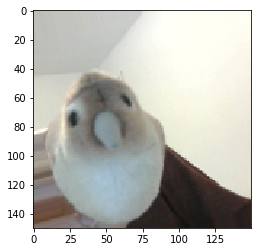

[1. 0. 0. 0.]


In [40]:
# Test generators

import matplotlib.pyplot as plt

index = 3

gen = datagen.flow(x_train, y_train, batch_size=20)
x,y = gen.next()
plt.imshow(x[index])
plt.show()
print(y[index])

In [43]:
epochs = 2
batch_size = 16

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
                    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                   class_weight = class_weight)

Epoch 1/2
71/70 [==============================] - 11s 151ms/step - loss: 0.6832 - accuracy: 0.8483 - val_loss: 0.3121 - val_accuracy: 0.8905
Epoch 2/2
71/70 [==============================] - 11s 157ms/step - loss: 0.6260 - accuracy: 0.8580 - val_loss: 0.2997 - val_accuracy: 0.8869


In [ ]:
# Evaluate model

val_loss, val_acc = model.evaluate(x_valid, y_valid);
print(val_loss)
print(val_acc)

In [44]:
# Save weights hdf5 format

#model.save_weights('pre-trained.h5')
model.save_weights('trained.h5')

In [45]:
# Save model in SavedModel format (tensorflow 2.0)

export_path = 'model'

tf.saved_model.save(model, export_path)

INFO:tensorflow:Assets written to: model/assets


In [ ]:
# Load model and test signature def (Tensorflow 2.0)

import numpy as np
import matplotlib.pyplot as plt

# Load model
loaded_model = tf.keras.models.load_model('model') 

# Predict function 
predict = loaded_model.signatures["serving_default"]

In [ ]:
# Predict using loaded model

index = 12

# Define input image
img = x_valid[index:index+1]/255.0

# Predict
prediction = predict(tf.constant(img, dtype=tf.float32))

# Show results
plt.imshow(x_valid[index])  # prints the image
print(prediction['graph_output'][0])  # prints the class number
print(labels_str[np.argmax(prediction['graph_output'][0])])

In [ ]:
prediction['graph_output'][0].numpy()

In [ ]:
a